In [ ]:
!pip install typing_extensions==4.7.1
!pip install gradio
!pip install feedparser
!pip install transformers accelerate
!pip install openai
!pip install tiktoken
!pip install wikipedia
!pip install python-dotenv

Found existing installation: typing_extensions 4.12.2
Uninstalling typing_extensions-4.12.2:
  Successfully uninstalled typing_extensions-4.12.2
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached ffmpy-0.5.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached MarkupSafe-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pillow-11.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached

# Part 1 - Podcast Transcription

## Step 1 - Retrieve the audio file

The first step is to get the RSS feed of the podcast, identify the latest episode and retrieve the audio file (typically in MP3 format). One of my favorite websites to find information about podcasts is [ListenNotes](https://www.listennotes.com/). You can search for any podcast you like and then click on the RSS icon to retrieve the RSS feed.

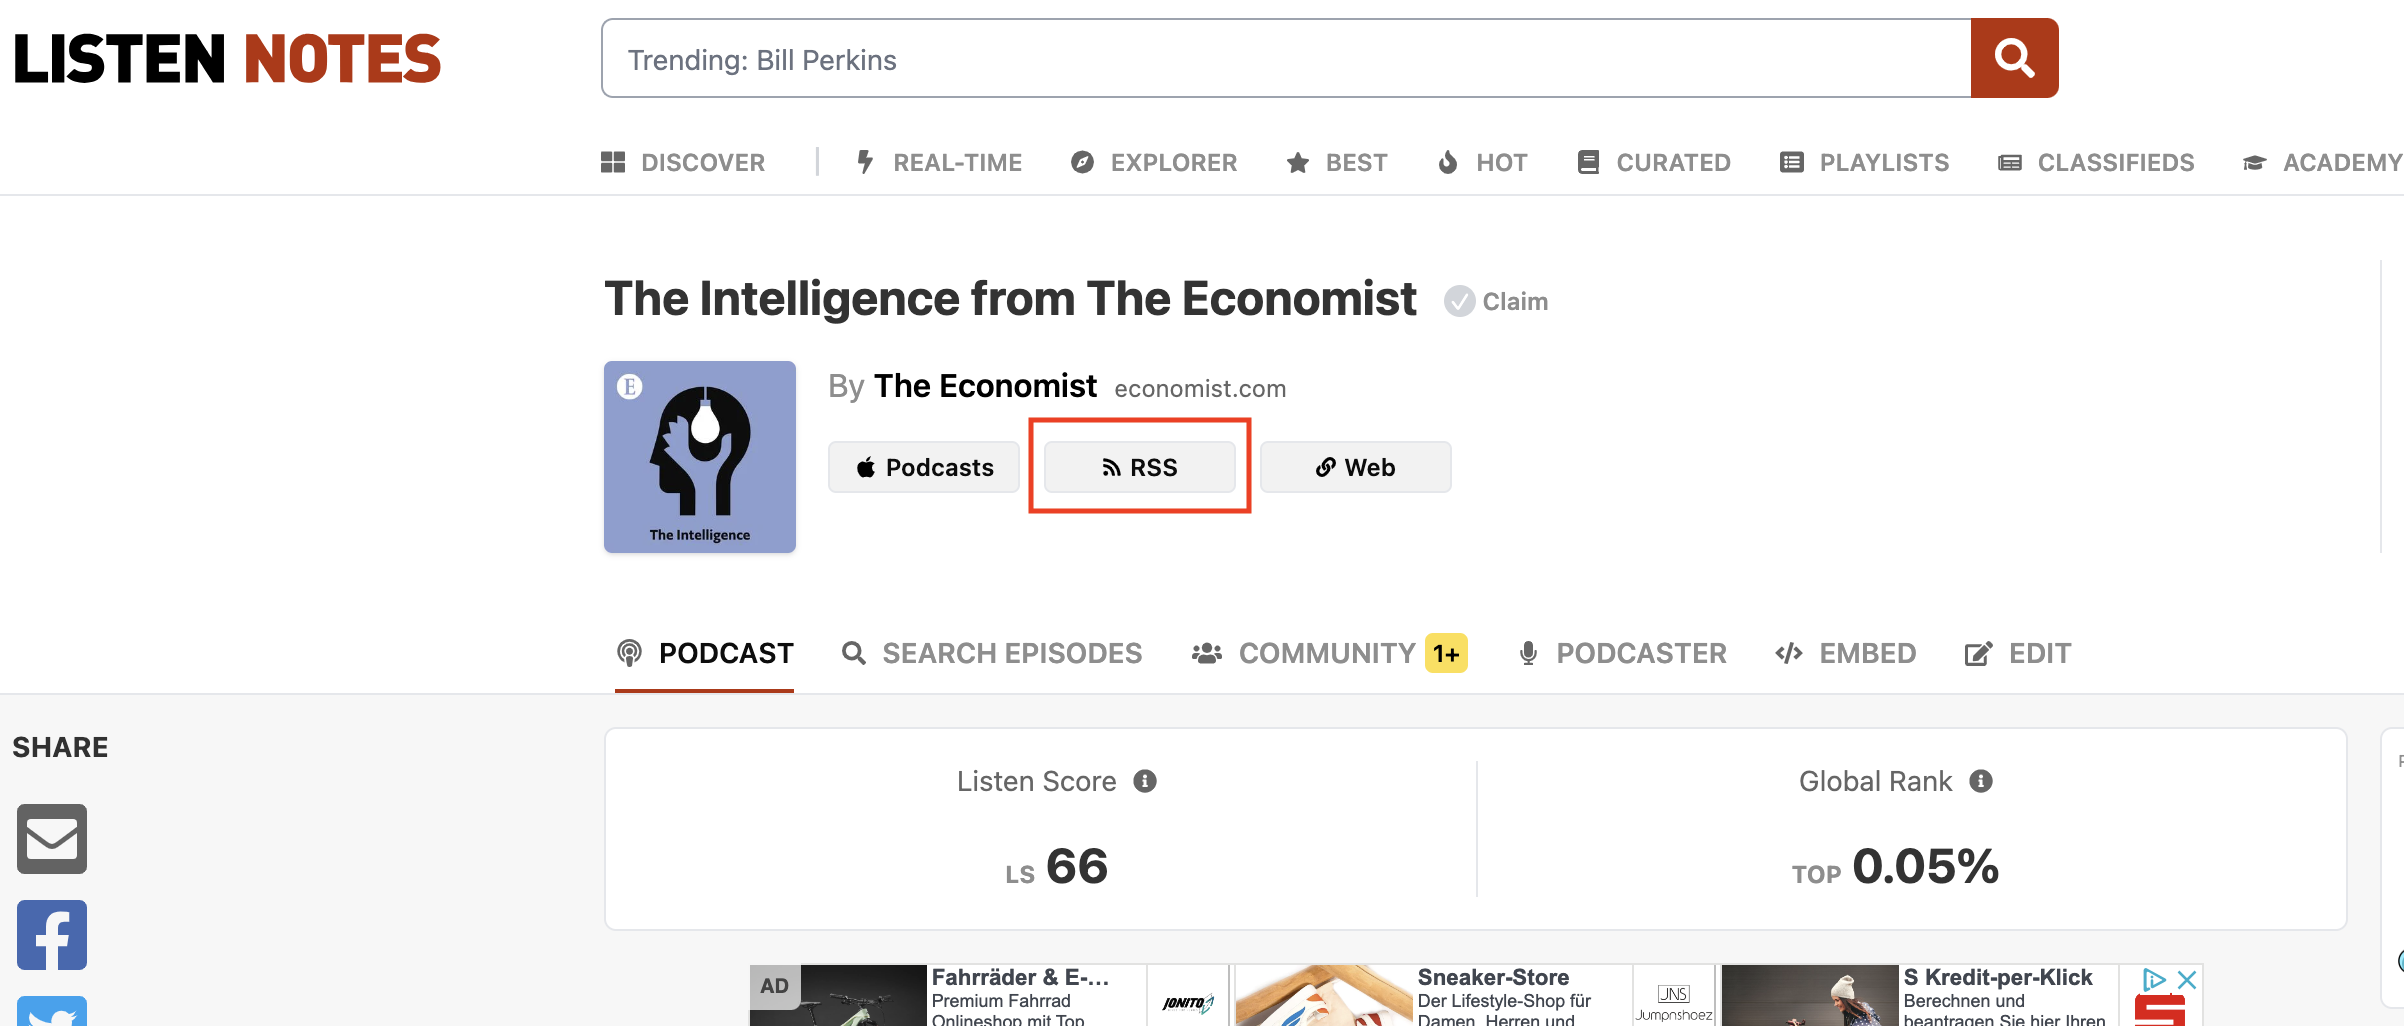

For example, The Economist publishes a daily news roundup podcast called [The Intelligence](https://www.listennotes.com/podcasts/the-intelligence-from-the-economist-the-stZlS3fr8KO/) which is quite concise and informative. Let's use the RSS feed of this podcast.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

This project works well for podcast episodes that have a run-time between 25-30 minutes. If you choose an episode that is longer in length, you might run into issues with transcription time (since it needs a GPU) and also with the token limit when making calls to OpenAI.

Transcribing longer podcasts is possible and you can add additional checks for token length and split it into multiple API calls to OpenAI. However, this is considered beyond the scope of this project.

In [1]:
import feedparser

#Enter the podcast feed URL
podcast_feed_url = "https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49"
podcast_feed = feedparser.parse(podcast_feed_url)

In [2]:
print ("The number of podcast entries is ", len(podcast_feed.entries))

The number of podcast entries is  1610


Let's get the URL of the most recent episode from the feed and then download the corresponding MP3 file and save it as `podcast_episode.mp3`

In [3]:
import os
import requests


# Ensure the download directory exists
download_dir = "./content/audio"
os.makedirs(download_dir, exist_ok=True)


episode_url = podcast_feed.entries[0].enclosures[0].href
response = requests.get(episode_url, stream=True)

if response.status_code == 200:
    with open("./content/audio/podcast_episode.mp3", "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print("Download complete!")
else:
    print("Failed to download:", response.status_code)


Download complete!


In [ ]:
# import os
# import requests

# # Ensure the download directory exists
# download_dir = "./content/audio"
# os.makedirs(download_dir, exist_ok=True)

# # Iterate through all podcast entries and download MP3 files
# for i, entry in enumerate(podcast_feed.entries):
#     if entry.enclosures:  # Ensure there's an enclosure
#         episode_url = entry.enclosures[0].href
#         file_name = f"podcast_episode_{i+1}.mp3"  # Unique filename
#         file_path = os.path.join(download_dir, file_name)
        
#         print(f"Downloading {episode_url} as {file_name}...")
        
#         response = requests.get(episode_url, stream=True)
#         if response.status_code == 200:
#             with open(file_path, "wb") as file:
#                 for chunk in response.iter_content(chunk_size=1024):
#                     file.write(chunk)
#             print(f"Downloaded: {file_name}")
#         else:
#             print(f"Failed to download {episode_url}")


## Step 2 - Transcribe the Audio file

We will use [Distill Whisper](https://huggingface.co/distil-whisper/distil-medium.en) as our speech to text model. The original model has been open-sourced by OpenAI and this version has been distilled (compressed) using additional fine-tuning so that it runs faster. There is a drop in the accuracy but for our use case this will not have a big impact.

In order to make use of HuggingFace, it's necessary to first create an [account](https://huggingface.co/), and agreeing to the Terms & Conditions. Once that is complete then run the below cell which will provide you with a link to your HuggingFace account where you can copy the token. Once you copy-paste it here then you will be able to pull and use many of the models that are hosted on HuggingFace hub.



In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
%%time

import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "distil-whisper/distil-medium.en"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=15,
    batch_size=16,
    torch_dtype=torch_dtype,
    device=device,
)

Device set to use cuda:0


CPU times: user 9.33 s, sys: 1.81 s, total: 11.1 s
Wall time: 28.2 s


/home/teng/development/projects/public/podcast-audio-transcription/podcastenv/lib/python3.10/site-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(


Now we need to pass in the location of our downloaded podcast file to get the transcript.

What this model is doing is chunking up the audio into 15 second chunks and then processing 16 of these chunks in one batch. This speeds up the process significantly compared to the original Whisper V2 implementation. This allows us to transcribe a 27 minute podcast in roughly 1 minute!

**NOTE**:
- This step will probably take longer to complete depending on the length of the podcast episode.
- We have created this notebook with the GPU runtime enabled and this will already speed things up. In the free version of Google Colab the notebook will most likely be assigned a T4 GPU which takes roughly a minute to transcribe a 30 minute episode.
- If you have a paid version of Google Colab, you can choose a different GPU like V100 or A100 to speed things up.

In [5]:
%%time

result = pipe("./content/audio/podcast_episode.mp3")
print(result["text"])

/home/teng/development/projects/public/podcast-audio-transcription/podcastenv/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 The Economist. Hello and welcome to the Intelligence from The Economist. I'm your host, Jason Palmer. Every weekday slashing and burning its way through the country's science institutions. We take stock of what's on the chopping block and assess how self-defeating it all is. And for lots of reasons, Brazil never really reckoned with the horrors of its 20-year dictatorship. Not as much as its neighbors, Chile, Uruguay, and Argentina did. Now an Oscar-nominated film is making Brazilians sit up and look to that past. First up though, though. In Gaza, almost six weeks ago, a temporary truce between Israel and Hamas began. Postages were freed. the bombs stopped at last, Palestinians returned to what was left of their homes. No one expected the progression to peace to be straightforward and it hasn't been. Just this morning Israel agreed to restart hostage exchanges after delaying them on Saturday in protest over the treatment of its detainees. Despite all these bumps in the road, a shaky p

In [6]:
# Check the transcription happened correctly by peeking into the first 1000 characters
podcast_transcript = result['text']
result['text'][:1000]

" The Economist. Hello and welcome to the Intelligence from The Economist. I'm your host, Jason Palmer. Every weekday slashing and burning its way through the country's science institutions. We take stock of what's on the chopping block and assess how self-defeating it all is. And for lots of reasons, Brazil never really reckoned with the horrors of its 20-year dictatorship. Not as much as its neighbors, Chile, Uruguay, and Argentina did. Now an Oscar-nominated film is making Brazilians sit up and look to that past. First up though, though. In Gaza, almost six weeks ago, a temporary truce between Israel and Hamas began. Postages were freed. the bombs stopped at last, Palestinians returned to what was left of their homes. No one expected the progression to peace to be straightforward and it hasn't been. Just this morning Israel agreed to restart hostage exchanges after delaying them on Saturday in protest over the treatment of its detainees. Despite all these bumps in the road, a shaky 

To avoid being in the situation that the Colab notebook shuts down and you loose the Python variable holding the transcription and to allow for faster testing of subsequent sections, we would recommend you create a local variable that holds your podcast transcript. You can print the contents of `podcast_transcript` from the previous cell and manually assign it to the variable.

This can be very helpful if you are not going through the notebook in one stretch and want to come back to different sections at a later point in time.

In [7]:
podcast_transcript

" The Economist. Hello and welcome to the Intelligence from The Economist. I'm your host, Jason Palmer. Every weekday slashing and burning its way through the country's science institutions. We take stock of what's on the chopping block and assess how self-defeating it all is. And for lots of reasons, Brazil never really reckoned with the horrors of its 20-year dictatorship. Not as much as its neighbors, Chile, Uruguay, and Argentina did. Now an Oscar-nominated film is making Brazilians sit up and look to that past. First up though, though. In Gaza, almost six weeks ago, a temporary truce between Israel and Hamas began. Postages were freed. the bombs stopped at last, Palestinians returned to what was left of their homes. No one expected the progression to peace to be straightforward and it hasn't been. Just this morning Israel agreed to restart hostage exchanges after delaying them on Saturday in protest over the treatment of its detainees. Despite all these bumps in the road, a shaky 

👨🏻‍💻📝 **Participant Input Required:** To prevent Colab time-out issues, please copy-paste the generated transcript in the cell below.


---

In [2]:
podcast_transcript = """
  The Economist. Hello and welcome to the Intelligence from The Economist. I'm your host, Jason Palmer. Every weekday slashing and burning its way through the country's science institutions. We take stock of what's on the chopping block and assess how self-defeating it all is. And for lots of reasons, Brazil never really reckoned with the horrors of its 20-year dictatorship. Not as much as its neighbors, Chile, Uruguay, and Argentina did. Now an Oscar-nominated film is making Brazilians sit up and look to that past. First up though, though. In Gaza, almost six weeks ago, a temporary truce between Israel and Hamas began. Postages were freed. the bombs stopped at last, Palestinians returned to what was left of their homes. No one expected the progression to peace to be straightforward and it hasn't been. Just this morning Israel agreed to restart hostage exchanges after delaying them on Saturday in protest over the treatment of its detainees. Despite all these bumps in the road, a shaky piece has somehow endured, but the threat of renewed violence has never been far away. Now the two sides are approaching a far more significant turning point without much of a plan in place. The first phase of the truce between Israel and Hamas is meant to expire on Saturday but the negotiations over the second phase haven't even started yet. Greg Krelstrom is a Middle East correspondent for the economist. Add to that some violations of the deal by both sides and increasingly strident rhetoric and I think we're in a very precarious situation where it's not at all clear that this deal is going to hold up for much longer. And Greg, it feels like we've actually heard relatively little out of Gaza about Gaza since the ceasefire began. Bring us up to date. Start with what has gone well in the ceasefire. It has largely held for the past five and a half weeks. Gaza has been comparatively calm. The fighting has stopped. Hamas has released all of the living hostages who were meant to be freed in the first phase of this agreement along with the bodies of some Israeli hostages who died in captivity. There's also been a lot more humanitarian aid over the past five and a half weeks. One of them is these rather grotesque rallies that Hamas has insisted on holding every time it releases hostages, parading them in front of crowds, making them thank their captors, kiss their captors on the head. This has understandably caused a lot of anger amongst Israelis. Another issue last week when Hamas handed over the bodies of an Israeli mother, Shiri Bebus and her two young children. It later turned out that the woman's body was not Shiri Bibati at all. It was an unidentified Palestinian woman. That too caused a lot of outrage in Israel. And then violations on the Israeli side as well, Palestinians in Gaza say they have not received the caravans the temporary homes that they expected to receive in phase one that so many people need especially in the middle of what is a very cold winter in Gaza right now. So that brings us to where we are now to this very tense situation at the end of phase one. And you mentioned that the first phase expires on Saturday but the second phase very much still to be worked out. What do you expect to see between now and then? I think you can imagine three different scenarios, only one of which I think you can imagine three different scenarios only one of which I think is realistic the first scenario is that the negotiators somehow managed to figure out phase two between now and Saturday. I think that's all but impossible. Steve Whitkoff, Donald Trump's Middle East envoy, not even expected to come back to the region until Sunday, so good luck getting anything done by Saturday. The second option is that this all falls apart in the next few days. There's a return to war over the weekend once the deal lapses. I think that's unlikely as well. It's not impossible which brings us to the most realistic option which is an extension of phase one. What Israel is pushing for what I think the Americans are pushing for as well is an extension of at least a few weeks. Hamas might release a few more trenches of hostages in that time in exchange for Palestinian prisoners and the hope is that that would at least buy some time for negotiators to start working on phase two. And let's sort of game this out if we could. If we do get to phase phase two what does that look like on the ground what comes after that that will start with an Israeli withdrawal from what's known as the Philadelphia corridor it's a strip of land on the border between Egypt and Gaza. That is meant to happen on March 9th. And then from there, the hopeful scenario is that you have a permanent end to the war in Gaza, a release of all of the remaining hostages in Hamas captivity, and then you talk about phase three, which is reconstruction, rebuilding of Gaza. Now there are various plans floating around for that. There were Arab states who met in Riyadh in Saudi Arabia on Friday. They are hashing out a plan which should be presented at an Arab League summit on March 4th, which would see a committee of Palestinian technocrats oversee reconstruction in Gaza. Egyptian firms would do a lot of the work. Gazans would supply the labor. Gulf states would pay for it broadly. That is the Arab proposal and it's being billed as an alternative to Donald Trump's wild plan to depopulate Gaza and build a resort there. We also heard Gaiy Lippid, the Israeli opposition leader speaking on Tuesday at a think tank in Washington suggesting his version of a plan which would be Egypt taking control of Gaza for a period of at least eight years in exchange for its foreign debts being written off. He said he didn't talk to the Egyptians about this plan. I'm not sure they would be on board with it. Also not sure he spoke to Egypt's creditors, but there are all of these proposals circulating for what the future of Gaza is going to look like. All of them have problems, all of them in their own ways, a bit unrealistic. You were hinting there that the Americans have been fairly crucial in this stage of negotiations, is that right? They've been instrumental throughout the whole process. Donald Trump has been, but when you listen to the messages coming out of Washington now the Americans are somewhat all over the place. Trump says he wants the deal to hold he wants to get to phase two but he also says he's okay with whatever Netanyahu and the Israelis decide to do. You listen to Steve Whitcoff, the president's Middle East envoy, he says he's confident about getting a deal, but he also says that as part of phase two Hamas needs to be exiled from Gaza which is going to be a non-starter with Hamas some of this you can look at it and say this is the Americans trying to build leverage trying to put pressure on Hamas but it might also be representative of genuine confusion on the part of a very chaotic administration so I think whether we get to phase two or not really is going to come down to whether Trump is willing to put pressure on Netanyahu to get the Israelis to phase two and it's not entirely clear right now if Trump is willing and able to do that. So in the scene of confusion that you've painted here there is still very much some chance that things could get back to war. I suppose it's worth thinking about what that might look like. There was a lot of talk last year about something called the Generals Plan which was drawn up by a group of retired Israeli generals and it was basically a proposal to lay siege to Northern Gaza cut off the flow of humanitarian aid entirely and declare anyone who was living there to be a valid military target. The rhetoric coming out of Israel over the past few weeks is that if the war resumes, they are going to put that plan into effect. They are going to go back into Gaza even more aggressively than they did over the previous 15 months. They are going to lay waste to large parts of the territory and they are going to impose even more onerous restrictions on the flow of humanitarian aid into the territory. Basically a scorched earth plan for Gaza. That is the rhetoric coming out of Israel. Now we've seen over the past 15 months that laying waste to Gaza hasn't actually achieved Israel's strategic goal of removing Hamas from power in the territory. But nonetheless, the messaging right now is that however bad things were in the first phase of the war, they can still get much worse. Greg, thanks very much for joining us. Thank you, Jason. I feel like we keep bringing up America's so-called Department of Government Efficiency or Doge, but it has effects way beyond the stated goal of trimming the federal workforce. See, to an economist, the word efficiency suggests something particular. Scarce resources being used optimally. In America, one such resource is scientific talent. Now that the bean counting bros have come for science institutions, suboptimal use of the resource is coming. We're going to see, I believe, talent moving overseas from the United States, and we're going to see less contribution to our global understanding of science. All this looks like a failure to run the numbers on what America actually gets out of its science. Never mind the fact that it's nabbed more Nobel Prizes than the next five countries combined or that it puts out nearly a quarter of the world's most cited papers. Simplifying a bit, science becomes technology, becomes business, becomes growth. America has long put a lot more money into science than a lot of its competitors and that has had huge returns on investment for the country as a whole. Rachel Dobbs is the economist's environment editor. It is thought to be responsible for a quarter of the country's productivity growth since the end of the Second World War and one economic analysis found that for every dollar of government spending on scientific research the return was between 150 and 300 percent but science funding now looks like it's on the chopping block because of some of the changes being made by the new Trump administration. Well talk me through those. How big of the cuts, where are they being cut? As part of Elon Musk's goal to get $2 trillion annually out of America's federal budget, agencies like the National Oceanic and Atmospheric Administration. Noah or the NSF, which is the National Science Foundation, have been told to prepare for cuts of their budget of up to 50% and downsizing of their staff of up to 30%. You've already seen mass layoff start across a lot of federal agencies including scientific ones. Is this just high-level trying to cut everybody in equal fashion or is there a focus here? It does look as if some of the things being cut are specifically targeted. One of the things that was announced as part of the Trump administration's push against DEI, which is diversity, equity and inclusion, was that all NSF grants had to be reviewed on that basis. And Ted Cruz, who's a Republican senator senator recently released a database of over 3000 NSF grants, which is roughly 10% of the grants that were allocated during the Biden-Harrass administration, that he said had been flagged for funding the radical left's woke nonsense and if you look through that data set which I did it is incredibly stark because you've got thousands and thousands of grants which have been flagged and they are just color-coded as being flagged race race, race, gender, gender, environmental justice, environmental justice, social justice. So not only are quite a lot of the ones flagged not to do with those topics at all, you've got some really ludicrous ones in there, which are words to do with bias bias which obviously has a specific scientific meaning. The phrase trans has been flagged at certain points but it has a specific scientific meaning like stuff happening across tectonic plates, but also a lot of the stuff that has been flagged is really important crucial scientific work like trying to work out how drugs are metabolized in people of different genders. And this isn't just sort of stopping the research in its tracks, it's also putting some of America's scientific talent out on their ear. Yeah, it is because these kind of cuts will mean that less scientific research can be done and that there will be less positions available to do it in and it also has made the whole situation feel much more uncertain and that will likely lead to people looking elsewhere. The deepest cuts currently proposed are to the grants allocated by the National Institutes of Health which run to roughly 43 billion a year, and are most of what that organization does. It's about 94% of their budget. And these cuts are already underway, or will be soon? Some of them are already underway. You've seen mass firings of probationary employees across federal agencies. Got about 5000 to have gone across the Department of Health and Human Services, more isolated for NOAA, more isolated for NASA. And the economist actually spoke to Monica Bertinoli, who is the former head of the NIH, who has defined what she thinks those kind of cuts will mean. It is my understanding, although it remains to be seen whether this definitely occurs, that the people losing their positions are not only people who've been recently hired, but also critical leaders who've been at NIH for a long time but were recently promoted. So this just frankly seems to me not any approach I've ever seen to organizing an agency to do the best it can for the American people. And so what I think Monica is trying to say that is that these kind of cuts are actually a terrible business decision and will leave these agencies in chaos. It is not just a case of kind of trimming the fat. This is going to have long running and possibly irreversible effects. And that obviously is coming on top of the proposed cuts to how the NIH funds what's known as indirect costs. So what do you mean by indirect costs? Indirect costs are stuff that does not go towards a specific project with a really exact or commercial application or to an individual researcher. It's more stuff that goes towards the shared resources that all of a faculty might use. That's stuff like a mass spectrometer or lab benches. That's stuff that then each individual grant doesn't have to be funding on its own. And it's also the stuff that allows what's known as basic research to really take place, which is kind of research that is done for the sake of expanding scientific knowledge. And often, that lays the really, really crucial building blocks of what then becomes the kind of really notable scientific discoveries but for that to happen there has to be this building block underneath and private grants which are often for applied research, typically don't cover that. So you need the ability for that research to be going on at the faculty level underneath it. And that is what a lot of these indirect costs are put towards. They have been characterized by the Trump administration, particularly by Enon Musk, as just completely egregious overheads and that these universities with huge endowments are just siphoning off these funds kind of just because they can and that really is definitely untrue. And this is a betrayal of the social contract that has existed in the United States since the end of World War II for the institutions and the federal government to co-build the infrastructure for American science that's carried out at universities. Holden Thorpe is the editor-in-chief of the Science Family of Journals. And if you suddenly pull the plug, the bill can be hundreds of millions of dollars at wealthy institutions, but it also is a large bill at smaller institutions that are just getting to the point where they can do research in places where the United States really needs them to be done. So I would encourage people, it's eye-popping to see that Yale's going to have to come up with $200 million or Stanford. But just think about what that means if the University of Rhode Island has to come up with $10 million. And so smaller universities and hospitals will be hit particularly hard, particularly in places or states that have a very high concentration of medical research and are known for doing it, many of whom are Republican states. And you've actually seen a couple of Republican senators come out very strongly on this basis like Susan Collins in Maine or Bill Cassidy in Louisiana, and they have said, you know, these cuts will be incredibly damaging for our constituents. But as for the economic motivations such as they are, will it work, will it save money? In the long term, I think definitely no because of the kind of return of investment that we see on this kind of science. In the short term, I think realistically probably no. It may show up on an immediate cut in the budget but will do very little to meaningfully save money. Rachel thanks very much for walking us through that. Thanks Jason. I'm still here is a Brazilian film set during the country's military dictatorship which ruled from 1964 to 1985. Anna Lancas is our Brazil Bureau Chief. And there's one scene towards the end that really struck me. A photographer is trying to take a picture of a woman and her five children and the father of the family has been disappeared by the dictatorship. They're all smiling and the photographer says, can you please look a little sad or the editor asked for a suitably unhappy photo and they defy his orders and they flash these toothy grins. It shows the resilience of the family but I also thought that on a broader level it kind of reflects how Brazil dealt with the legacy of its dictatorship. I used to live in Argentina and in Argentina the history of the dictatorship is still incredibly present but when I moved to Brazil last year I was shocked because there hasn't been the same level of reckoning and I'm still here is now finally spurring a reckoning with Brazil's violent past. The film came out in November and it's already one of the most watched films in Brazilian history and it's competing in three categories in the Oscars for Best Picture, Best International Film, and its lead stowical actress, Fernando Torres, is competing for Best Actress. The film follows the family of Huben's Piva as they deal with his disappearance. Piva was a left-leaning congressman who was immediately ousted after the coup of 1964. But for several years the dictatorship was fairly calm and then in the 1970s it really tightened its grip and in 1971 regime Thugs knocked on Piva's door in Rio de Janeiro and took him in for questioning. He never came out. For decades the army pushed a really implausible and convoluted story that Piva had basically escaped their grip and joined a guerrilla group. But in 2014 a National Truth Commission which interviewed thousands of people published evidence that he had actually been tortured and he died during his interrogation. Five retired officers were charged with killing him and with hiding his body. But so far, none of those officers has been tried, and three have already died of old age. The fact that nobody in Brazil is in jail for crimes committed during the dictatorship is pretty unusual. Across South America military leaders were in power during the 70s and 80s and in most countries they negotiated transition to democracy only after securing amnesties for themselves and their underlings. In Argentina, Chile and Uruguay, though, those pardons were basically annulled. And where they weren't entirely annulled, courts went after the worst offenders. But in Brazil things were different. Brazil's Supreme Court upheld its amnesty and civil society by and large went along with it. The military returned to the barracks after 1985 and it let a budding left-wing movement thrive. The differences in these outcomes comes down to the relative brutality of the regimes and also to the popularity and power of the militaries at the point of transition to democracy. So if you put them on a spectrum, Argentina's dictatorship was by far the most brutal. So after the dictatorship, a really powerful human rights movement emerged and over a thousand people are in jail in Argentina for crimes committed during the dictatorship. Chile comes after Argentina its regime was also very bloody. Uruguay's regime preferred imprisoning opponents rather than murdering them and Brazil's regime on that spectrum was the least savage. The army killed at least 434 people and tortured thousands more. But at the beginning of the dictatorship, Brazil won the football world cup. And there it is. Brazil become the first team to ever win the World Cup three times. And for the first few years, the economy was booming. All of that means that Brazil does not have the same traumatic memory that Argentina, Chile and Uruwa did. But now the success of I'm still here is making a lot of Brazilians rethink their clemency. So in January, registry offices started updating death certificates for people disappeared during the dictatorship to reflect the real causes of their death. And then on February 14th an official commission that looks into political killings said that it might re-examine the death of Jusilino Kubi Czech, who's a former president who died in suspicious circumstances in 1976, along with another former president and a very important politician. And on the same day Brazil Supreme Court started deliberating on whether the amnesty should apply in the case of Rubens Paiva and two other disappeared dissidents or whether protecting the prosecutors conflicts with international human rights treaties that Brazil has signed. It's very rare that a single film spurs such profound discussion in a country. The film feels newly relevant. In November when it came out I came on the show to talk about a report that the federal police had just released that Jayar Bolsonaro, a former far-right president, basically tried to stage a coup to stay in power after the 2022 elections. And a lot of people in the army supported him. Bolsonaro denies wrongdoing and he says that he's being politically persecuted. So there was a sense among a lot of people when this film came out that Brazil's military hadn't quite learned the lesson that it needed to stay in the barracks and hand over power to civilians. On February 18th, Brazil's attorney general basically confirmed the findings of the federal police and that means that Bolsonaro will now be tried by the Supreme Court. But there is an interesting twist to all of this which is that Bolsonaro also has personal beef with the Puyva family. He grew up in the same town as them. In 2014 when the National Truth Commission confirmed that Rubenspaiva had been killed by the military, a bust of him was brought into Congress. The family of Rubenspaiva was there and Bolsonaro spat on the bust in front of the family and said that Rubens-Pyva got what he deserved. So I think I'm still here has resonated particularly strongly in Brazil right now because it's not just a film about its past, it's also about the present. You're That's all for this episode of the Intelligence. We'll see you back here tomorrow. Thank you.
"""

### Extensions

1. Instead of downloading and running the transcription ourselves, you can also use the hosted version of the OpenAI Whisper model (paid). For more details, you can check the [documentation](https://platform.openai.com/docs/models/whisper).
2. The Whisper model does not provide speaker identification but just transcribes what was said. In some situations, it would be good to identify when there are different speakers in the podcast and seperate their dialogues. There are many [libraries](https://github.com/m-bain/whisperX) that work on top of Whisper to enable this.

# Part 2 - Information Extraction

## Step 1 - Creating a summary of the podcast

As part of the information extraction, we would first like to create a summary of the podcast. We want this to be concise while still conveying the gist of the episode and trying to catch the attention of the user. We will use the OpenAI `gpt-4o-mini` model to generate this summary by passing in the generated transcript. We are asking the LLM to go through the entire transcript we provide and summarize it for us.

We need to use the `openai` and `tiktoken` libraries. The openai library is the Python package that allows us to make calls to the API. The tiktoken library allows us to determine the number of tokens in our transcript and that gives us an indication of costs and also whether we will need to change the model that we use to one with a larger context window. While we can use the API and make calls directly, it's much easier to work with the Python library provided by OpenAI called - `openai` 🤭.

If you have already performed these steps as part of the Lecture notebook and have the API key, then you can simply proceed to the next step.

Before using the OpenAI API, you need to get an API token. Please create an account with OpenAI by visiting this [link](https://platform.openai.com/) and creating an account with a method of your choice. This will allow us to access the API. Once created, please naviagate to the `Manage Accounts` section of your profile and look-up the `Usage` tab. By default, most new accounts automatically get $5 of credit to try the API and this should be enough for the purposes of this project.

Please also visit the `API Keys` tab and Create a new secret key and copy this and keep it available. We will use this API key in subsequent steps while making the API calls.

Please enter your OpenAI key on the Security tab in the left pane of Google Colab as described below.

---

Once you have copied the API key, please click the Security Key icon on the left hand tab of the Google Colab notebook and then add a new parameter value called OPENAI_API_KEY. Here you can provide the API key that you copied and this will not be part of your Google Colab account. You can also enable the toggle `Notebook access` - this will allow your notebook to have access to this API key.

After this, running the following cell will automatically take the API key which will be used for subsequent calls to the OpenAI API.

If you have a Professional GitHub account with access to the models, you can insert your github personal authentication token in a `.env` file and it will load. If running the notebook in google colab then you can follow the steps above but save the key in a variable named `GITHUB_TOKEN`

In [ ]:
# from openai import OpenAI
# from google.colab import userdata

# client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

In [9]:
import os
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

client = OpenAI(
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ["GITHUB_TOKEN"]
)

**Context Window**

It's important to understand the concept of a context window. This is the maximum of the combined text that can be used in one API call to the gpt-3.5-turbo model. It is not only a combination of the input text sent to the model but also takes into consideration the output response as well. Also keep in mind that this is measured in terms of tokens and not words. While we could treat them as analogous, it's technically not the same as one word may actually be broken down into multiple tokens.

It's always best to use the tiktoken package to determine the number of tokens in your text.

In [10]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4o-mini")
print ("Number of tokens in input prompt ", len(enc.encode(podcast_transcript)))

Number of tokens in input prompt  4620


Please enter the prompt that you would like to use to summarize the podcast in the cell below.


---

In [11]:
instructPrompt = """
You are an expert copywriter who is responsible for publishing newsletters with thousands of subscribers. You recently listened to a great podcast
and want to share a summary of it with your readers. Please write the summary of this podcast making sure to cover the important aspects that were
discussed and please keep it concise.
The transcript of the podcast is provided below"""

request = instructPrompt + podcast_transcript

In [12]:
chatOutput = client.chat.completions.create(model="gpt-4o-mini",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [13]:
podcastSummary = chatOutput.choices[0].message.content
podcastSummary

"**Podcast Summary: The Intelligence from The Economist**\n\nIn this episode of *The Intelligence*, host Jason Palmer delves into two major topics: the fragile ceasefire between Israel and Hamas and the impact of a new Brazilian film prompting a reevaluation of the country’s military dictatorship.\n\n**Israel-Hamas Ceasefire Overview**\n\nThe podcast begins by assessing the current situation in Gaza, nearly six weeks into a temporary ceasefire that has allowed for a temporary halt in hostilities and the release of hostages by Hamas. Despite these developments, tensions remain high with threats of renewed violence as negotiations for a second phase of the truce have not yet commenced. Greg Krelstrom, the Middle East correspondent, outlines the complexities:\n- Both sides have violated parts of the ceasefire agreement.\n- While humanitarian aid has increased, expectations have not been met in some areas, causing frustration among Palestinians.\n- With the deadline for the ceasefire loomi

In [14]:
print(podcastSummary)

**Podcast Summary: The Intelligence from The Economist**

In this episode of *The Intelligence*, host Jason Palmer delves into two major topics: the fragile ceasefire between Israel and Hamas and the impact of a new Brazilian film prompting a reevaluation of the country’s military dictatorship.

**Israel-Hamas Ceasefire Overview**

The podcast begins by assessing the current situation in Gaza, nearly six weeks into a temporary ceasefire that has allowed for a temporary halt in hostilities and the release of hostages by Hamas. Despite these developments, tensions remain high with threats of renewed violence as negotiations for a second phase of the truce have not yet commenced. Greg Krelstrom, the Middle East correspondent, outlines the complexities:
- Both sides have violated parts of the ceasefire agreement.
- While humanitarian aid has increased, expectations have not been met in some areas, causing frustration among Palestinians.
- With the deadline for the ceasefire looming, three 

## Step 2 - Using `functions` to extract additional information to provide additional context on the episode

We can provide additional context to the listener about a certain episode if we are able to identify the guest and add a summary of their background and experience.

We can easily find information about the guest using Wikipedia or Google but first we also need to extract the name of the podcast guest. Since we are looking to pass the extracted name of the podcast guest to a subsequent function, we need to ensure that the output we recieve from the API is as structured as possible.

To achieve this, we are going to make use of the `function calling` capability of OpenAI API.

- The way to achieve this is by defining a function with very clear information on what it expects and in which format. This is specified as a separate input to the chat completion endpoint as you see below.
- Typically in a podcast episode the guest will be introduced in the first half and therefore it's not necessary to use the entire transcript to extract this information.
- We pass in only the first 5000 characters and this will save us token usage as well and therefore we can use the non 16k model.

In [15]:
request = podcast_transcript[:5000]
enc = tiktoken.encoding_for_model("gpt-4o-mini")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

Number of tokens in input prompt  1016


In [16]:
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": request}],
    functions=[
        {
            "name": "get_podcast_guest_information",
            "description": "Get information on the podcast guest using their name to search on Wikipedia",
            "parameters": {
                "type": "object",
                "properties": {
                    "guest_name": {
                        "type": "string",
                        "description": "The name of the guest who is speaking in the podcast",
                    },
                    "unit": {"type": "string"},
                },
                "required": ["guest_name"],
            },
        }
    ],
    function_call={"name": "get_podcast_guest_information"}
)

We can directly see how the output from the API is formatted by checking the response object `completion`

In [20]:
completion

ChatCompletion(id='chatcmpl-B5H4d3joErWoK51uVsmQHLz81HEcQ', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=FunctionCall(arguments='{"guest_name":"Greg Krelstrom"}', name='get_podcast_guest_information'), tool_calls=None), content_filter_results={})], created=1740596971, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_b705f0c291', usage=CompletionUsage(completion_tokens=9, prompt_tokens=1100, total_tokens=1109, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filter

In [17]:
import json

podcast_guest = ""
response_message = completion.choices[0].message

# Debugging: Print the response message structure
print("Response Message:", response_message)

if response_message and response_message.function_call:
    function_name = response_message.function_call.name
    function_args = json.loads(response_message.function_call.arguments)

    # Debugging: Print extracted function call details
    print("Function Name:", function_name)
    print("Function Arguments:", function_args)

    podcast_guest = function_args.get("guest_name", "No guest found")

print("Podcast Guest is:", podcast_guest)


Response Message: ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=FunctionCall(arguments='{"guest_name":"Greg Krelstrom"}', name='get_podcast_guest_information'), tool_calls=None)
Function Name: get_podcast_guest_information
Function Arguments: {'guest_name': 'Greg Krelstrom'}
Podcast Guest is: Greg Krelstrom


It looks like the output is formatted with JSON and in a structured way that allows us to use this output directly.

In [18]:
import json

podcast_guest = ""
response_message = completion.choices[0].message
if response_message.function_call:
    function_name = response_message.function_call.name
    function_args = json.loads(response_message.function_call.arguments)
    podcast_guest=function_args.get("guest_name")

print ("Podcast Guest is ", podcast_guest)

Podcast Guest is  Greg Krelstrom


### Extensions

1. Sometimes it's possible that guest extraction may happen partially or not at all. We can still attempt to find more information about the podcast guest by extracting additional information about them like their organization or title.
2. Depending on the podcast and generated transcript, it's also possible that extraction is incorrect and we need to include error handling for these conditions.
3. In order to find more infromation about the guest, you could consider extracting this information from external APIs like Wikipedia, Google Search or Databases like Crunchbase depending on your use-case.

#### Extension Solution 1

Let's consider the case where podcast guest name may not be enough OR it has not been extracted well or completely. One way to resolve this would be to extract additional information:

- Podcast Guest Organization
- Podcast Guest Title

You can also adjust the prompt to say that we would like to extract the `full name` of the podcast guest. This helps the model understand our intention better. We can also provide more context by including the larger portion (first 10k characters) from the start of the podcast transcript as that's where organization, title and such details might be covered during their introduction.

Let's see what this function looks like.

In [19]:
request = podcast_transcript[:10000]
enc = tiktoken.encoding_for_model("gpt-4o-mini")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

Number of tokens in input prompt  2012


In [20]:
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": request}],
    functions=[
        {
            "name": "get_podcast_guest_information",
            "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
            "parameters": {
                "type": "object",
                "properties": {
                    "guest_name": {
                        "type": "string",
                        "description": "The full name of the guest who is speaking in the podcast",
                    },
                    "guest_organization": {
                        "type": "string",
                        "description": "The full name of the organization that the podcast guest belongs to or runs",
                    },
                    "guest_title": {
                        "type": "string",
                        "description": "The title, designation or role of the podcast guest in their organization",
                    },
                },
                "required": ["guest_name"],
            },
        }
    ],
    function_call={"name": "get_podcast_guest_information"}
)

In [21]:
completion

ChatCompletion(id='chatcmpl-B9S55evbZDFT7TohXKS6QTto0b5cd', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=FunctionCall(arguments='{"guest_name":"Rachel Dobbs","guest_organization":"The Economist","guest_title":"environment editor"}', name='get_podcast_guest_information'), tool_calls=None), content_filter_results={})], created=1741592595, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_ded0d14823', usage=CompletionUsage(completion_tokens=21, prompt_tokens=2148, total_tokens=2169, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'ja

In [22]:
import json

podcast_guest = ""
podcast_guest_org = ""
podcast_guest_title = ""
response_message = completion.choices[0].message
if response_message.function_call:
    function_name = response_message.function_call.name
    function_args = json.loads(response_message.function_call.arguments)
    podcast_guest=function_args.get("guest_name")
    podcast_guest_org=function_args.get("guest_organization")
    podcast_guest_title=function_args.get("guest_title")

In [23]:
print (podcast_guest)
print (podcast_guest_org)
print (podcast_guest_title)

Rachel Dobbs
The Economist
environment editor


Let's consider that we use Wikipedia to search for a page that lists more information about the guest of the show.

In [24]:
if podcast_guest_org is None:
    podcast_guest_org = ""
if podcast_guest_title is None:
    podcast_guest_title = ""

In [25]:
import wikipedia

# Ensure values exist before searching
search_query = f"{podcast_guest} {podcast_guest_org} {podcast_guest_title}".strip()

if search_query:
    try:
        search_results = wikipedia.search(search_query, results=5)  # Get top 3 results
        if search_results:
            page = wikipedia.page(search_results[0])  # Use the first result
            print("Wikipedia Page:", page.title)
            print("Summary:", page.summary[:500])  # Print first 500 characters
        else:
            print("No Wikipedia page found for this guest.")
    except wikipedia.exceptions.DisambiguationError as e:
        print("Multiple possible Wikipedia pages:", e.options)
    except wikipedia.exceptions.PageError:
        print("No Wikipedia page found.")
else:
    print("No guest information available to search.")


Wikipedia Page: List of University of Oxford people with PPE degrees
Summary: Philosophy, Politics and Economics (PPE) at Oxford University has traditionally been a degree read by those seeking a career in politics,  public life (including senior positions in His Majesty's Civil Service) and journalism.
This list does not include those notable figures, such as former U.S. President Bill Clinton, who studied PPE at the university but did not complete their degrees.


In [26]:
page.summary

"Philosophy, Politics and Economics (PPE) at Oxford University has traditionally been a degree read by those seeking a career in politics,  public life (including senior positions in His Majesty's Civil Service) and journalism.\nThis list does not include those notable figures, such as former U.S. President Bill Clinton, who studied PPE at the university but did not complete their degrees."

## Step 3: Extract the highlights of the podcast

We've provided our reader with a summary of the podcast and more information about the guest on this episode. What if we could also give them a peak into the conversation?

In this step, we want to extract some key moments in the podcast. These are typically interesting insights from the guest or critical questions that the host might have put forward. It could also be a discussion on a hot topic or controversial opinion.  

In [27]:
instructPrompt = """
Role:
You are an advanced AI assistant specializing in analyzing podcast transcripts. Your goal is to extract the most insightful, engaging, and controversial moments from a podcast conversation.

Task:
Given the podcast transcript, identify and extract key moments based on the following categories:

Guest Insights – Notable statements, expert opinions, or impactful personal stories from the guest.
Critical Questions – Thought-provoking or challenging questions asked by the host.
Hot Topics or Controversies – Discussions on trending or controversial subjects.

If timestamps are present in the transcript (e.g., [00:12:34] format), include them in the response.

"""

request = instructPrompt + podcast_transcript

In [28]:
chatOutput = client.chat.completions.create(model="gpt-4o-mini",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [29]:
podcastHighlights = chatOutput.choices[0].message.content

In [30]:
print(podcastHighlights)

Here are the key moments extracted from the podcast based on the specified categories:

### Guest Insights
- **Greg Krelstrom on Israel-Hamas truce:** "[00:05:32]... it's not at all clear that this deal is going to hold up for much longer."
- **Rachel Dobbs on U.S. scientific talent:** "[00:13:39]... I believe talent moving overseas from the United States, and we're going to see less contribution to our global understanding of science."
- **Anna Lancas on Brazil's military dictatorship:** "[00:24:47]... the success of *I'm Still Here* is making a lot of Brazilians rethink their clemency."

### Critical Questions
- **Jason Palmer’s question on Gaza ceasefire:** "[00:06:05]... What do you expect to see between now and then?"
- **Regarding the proposed cuts to scientific funding:** "[00:14:14]... is this just high-level trying to cut everybody in equal fashion or is there a focus here?"
- **On the potential impact of *I'm Still Here* on Brazilian society:** "[00:29:52]... How is this film

### Extensions

There are additional pieces of information that you might choose to extract like
    - the key topics that are being discussed in the episode
    - extract the timestamp along with the highlights so that a user could navigate directly to the location in the podcast where that discussion happens
    - build chapters of the podcast and identify their title


In the previous section we saw that we are able to use the OpenAI API to extract the required information rather easily, the output is delivered in a structured way allowing us to call downstream APIs and much more. This shows us that we could possibly build a product in this direction.

## Step 4: Defining information extraction steps as functions

So far, we have been testing the OpenAI API and prompts to extract information from the podcast episode. This is an interactive style of programming when starting to work on a problem and figuring out whether the approach makes sense. As we become more confident of our solution, it makes sense to modularise the logic and prompts into separate functions to make our code robust and easily repeatable/callable from other parts of our code.

This is especially important at this stage of the project as we want to create a front-end and would like to call the information extraction functions that will serve as the back-end.

In the below sections, we gather all the information extraction steps that we experimented with so far into clearly defined functions. We will create a `process_podcast` function that carries out a series of steps starting from podcast transcription, followed by summarization, podcast guest extraction and identifying highlights. You can imagine this to be our workflow.

We start by defining the function `download_podcast_episode` that takes in the RSS feed and downloads the latest podcast episode as an MP3 file. 

In [32]:
import os
import datetime

def download_podcast_episode(rss_url, local_path="./content/audio"):
    print ("Starting Podcast Transcription Function")
    print ("Feed URL: ", rss_url)

    # Read from the RSS Feed URL
    import feedparser

    intelligence_feed = feedparser.parse(rss_url)
    podcast_title = intelligence_feed['feed']['title']
    episode_title = intelligence_feed.entries[0]['title']
    episode_image = intelligence_feed['feed']['image'].href
    for item in intelligence_feed.entries[0].links:
        if (item['type'] == 'audio/mpeg'):
            episode_url = item.href
    episode_name = "podcast_episode_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".mp3"
    print ("RSS URL read and episode URL: ", episode_url)

    # Setup the path variable
    from pathlib import Path
    p = Path(local_path)
    p.mkdir(exist_ok=True)

    # Download the latest podcast episode
    print ("Downloading the podcast episode")

    import requests

    with requests.get(episode_url, stream=True) as r:
        r.raise_for_status()
        episode_path = p.joinpath(episode_name)
        with open(episode_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print ("Podcast Episode downloaded")
    return episode_path, podcast_title, episode_title, episode_image

We then define the `transcribe_podcast_episode` function that takes in the location of the downloaded podcast file and transcribes it using Distill Whisper model.

In [33]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

def transcribe_podcast_episode(episode_path):
    # Run the transcription process
    print (episode_path)
    processor = AutoProcessor.from_pretrained(model_id)

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        max_new_tokens=128,
        chunk_length_s=15,
        batch_size=16,
        torch_dtype=torch_dtype,
        device=device,
    )

    result = pipe("./content/audio/podcast_episode.mp3")
    podcast_transcript = result["text"]
    print ("Podcast Transcription Completed")
    return podcast_transcript

Finally we add all the information extraction functions - `get_podcast_summary`, `get_podcast_guest` and `get_podcast_highlights` which each make calls to the OpenAI LLM.

In [34]:
import os
from openai import OpenAI
# from google.colab import userdata
from dotenv import load_dotenv

load_dotenv()

# client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
client = OpenAI(
    base_url="https://models.inference.ai.azure.com",
    api_key=os.environ["GITHUB_TOKEN"]
)


def get_podcast_summary(podcast_transcript):
    instructPrompt = """
    You are an expert copywriter who is responsible for publishing newsletters with thousands of subscribers. You recently listened to a great podcast
    and want to share a summary of it with your readers. Please write the summary of this podcast making sure to cover the important aspects that were
    discussed and please keep it concise.
    The transcript of the podcast is provided below.
    """
    request = instructPrompt + podcast_transcript
    chatOutput = client.chat.completions.create(model="gpt-4o-mini",
                                              messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                        {"role": "user", "content": request}
                                                        ]
                                              )
    podcastSummary = chatOutput.choices[0].message.content
    return podcastSummary

def get_podcast_guest(podcast_transcript):
    import wikipedia
    import json
    request = podcast_transcript[:10000]
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": request}],
        functions=[
        {
            "name": "get_podcast_guest_information",
            "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
            "parameters": {
                "type": "object",
                "properties": {
                    "guest_name": {
                        "type": "string",
                        "description": "The full name of the guest who is speaking in the podcast",
                    },
                    "guest_organization": {
                        "type": "string",
                        "description": "The full name of the organization that the podcast guest belongs to or runs",
                    },
                    "guest_title": {
                        "type": "string",
                        "description": "The title, designation or role of the podcast guest in their organization",
                    },
                },
                "required": ["guest_name"],
            },
        }],
        function_call={"name": "get_podcast_guest_information"})
    response_message = completion.choices[0].message

    # Extract the relevant information
    podcast_guest = ""
    podcast_guest_org = ""
    podcast_guest_title = ""

    if response_message.function_call:
        function_name = response_message.function_call.name
        function_args = json.loads(response_message.function_call.arguments)
        podcast_guest=function_args.get("guest_name")
        podcast_guest_org=function_args.get("guest_organization")
        podcast_guest_title=function_args.get("guest_title")

    if (podcast_guest is not None):
        if (podcast_guest_org is None):
            podcast_guest_org = ""
        if (podcast_guest_title is None):
            podcast_guest_title = ""
        try:
            input = wikipedia.page(podcast_guest + " " + podcast_guest_org + " " + podcast_guest_title, auto_suggest=True)
            podcast_guest_summary = input.summary
        except wikipedia.exceptions.PageError:
            print(f'The page for guest "{podcast_guest}" does not exist on Wikipedia.')
            podcast_guest_summary = "Not Available"
        except wikipedia.exceptions.DisambiguationError as e:
            print(f'The page for guest "{podcast_guest}" is ambiguous. Possible matches are:')
            print(e.options)
            podcast_guest_summary = "Not Available"
    else:
        podcast_guest = "Not Available"
        podcast_guest_org = "Not Available"
        podcast_guest_title = "Not Available"
        podcast_guest_summary = "Not Available"

    podcastGuest = {}
    podcastGuest['name'] = podcast_guest
    podcastGuest['org'] = podcast_guest_org
    podcastGuest['title'] = podcast_guest_title
    podcastGuest['summary'] = podcast_guest_summary
    return podcastGuest

def get_podcast_highlights(podcast_transcript):
    instructPrompt = """
    You are a podcast editor and producer. You are provided with the transcript of a podcast episode and have to identify the 5 most significant moments in the podcast as highlights.
    - Each highlight needs to be a statement by one of the podcast guests
    - Each highlight has to be impactful and an important takeaway from this podcast episode
    - Each highlight must be concise and make listeners want to hear more about why the podcast guest said that
    - The highlights that you pick must be spread out throughout the episode

    Provide only the highlights and nothing else. Provide the full sentence of the highlight and format it as follows -

    - Highlight 1 of the podcast
    - Highlight 2 of the podcast
    - Highlight 3 of the podcast
      """
    request = instructPrompt + podcast_transcript
    chatOutput = client.chat.completions.create(model="gpt-4o-mini",
                                              messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                        {"role": "user", "content": request}
                                                        ]
                                              )
    podcastHighlights = chatOutput.choices[0].message.content
    return podcastHighlights

Finally, we create the `process_podcast` function that defines the entire pipeline and provides us the output in a dictionary file.

In [35]:
def process_podcast(url):
    output = {}
    podcast_episode_path, podcast_title, episode_title, episode_image = download_podcast_episode(url)
    podcast_transcription = transcribe_podcast_episode(podcast_episode_path)
    podcast_summary = get_podcast_summary(podcast_transcription)
    podcast_guest = get_podcast_guest(podcast_transcription)
    podcast_highlights = get_podcast_highlights(podcast_transcription)
    output['podcast_title'] = podcast_title
    output['episode_title'] = episode_title
    output['episode_image'] = episode_image
    output['podcast_summary'] = podcast_summary
    output['podcast_guest'] = podcast_guest
    output['podcast_highlights'] = podcast_highlights
    output['podcast_transcription'] = podcast_transcription
    return output

As a way to test the entire process, we can call it directly with a podcast RSS URL of your choice.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

As noted in Part 1, please make sure that any podcast you choose has episodes in the 25-30 minute range.

In [36]:
%%time
# Let's test our entire podcast process
out = process_podcast("https://feeds.megaphone.fm/HS6260485755")

Starting Podcast Transcription Function
Feed URL:  https://feeds.megaphone.fm/HS6260485755
RSS URL read and episode URL:  https://pdst.fm/e/chrt.fm/track/28555/pdrl.fm/9693cc/tracking.swap.fm/track/AwSmAF8PeQlxyS7Q0R8T/traffic.megaphone.fm/HS2940243394.mp3?updated=1741579924
Podcast Episode downloaded
content/audio/podcast_episode_20250310_104504.mp3


Device set to use cuda:0
/home/teng/development/projects/public/podcast-audio-transcription/podcastenv/lib/python3.10/site-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(
/home/teng/development/projects/public/podcast-audio-transcription/podcastenv/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Podcast Transcription Completed
The page for guest "Greg Krelstrom" does not exist on Wikipedia.
CPU times: user 24.1 s, sys: 712 ms, total: 24.8 s
Wall time: 42 s


As an additional helper function, we can save the produced podcast summaries and other information into a JSON file that can be retrieved by the front-end.

In [37]:
import json
import datetime


filename = f"./content/texts/podcast-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".json"
with open(filename, "w") as outfile:
    json.dump(out, outfile)

Since we are building a front-end app in the next section, we don't want to be waiting for 5 mins for the details of our podcast to load. So you can repeat this process for multiple podcasts of your choice to create a pre-defined list for your front-end. This is useful to pre-populate the app with existing summaries to show the user what kind of information can be extracted and provide some samples.

In [ ]:
%%time

import json

def create_podcast_json(podcast_name, podcast_feed_url):
    out = process_podcast(podcast_feed_url)
    filename = f"./content/texts/podcast-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    with open(filename + "-" + podcast_name + ".json", "w") as outfile:
        json.dump(out, outfile)

def create_podcast_json(podcast_name, podcast_feed_url):
    sanitized_podcast_name = podcast_name.replace(" ", "-").lower()
    out = process_podcast(podcast_feed_url)
    filename = f"./content/texts/podcast-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    with open(filename + "-" + sanitized_podcast_name + ".json", "w") as outfile:
        json.dump(out, outfile)

# Let's test our entire podcast process
podcast_feed_url = "https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49"
podcast_name = "The Hustle Daily Listen"
# podcast_name = f"./content/texts/podcast-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
create_podcast_json(podcast_name, podcast_feed_url)

Starting Podcast Transcription Function
Feed URL:  https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49
RSS URL read and episode URL:  https://sphinx.acast.com/p/acast/s/theintelligencepodcast/e/67cace9d22c74795c3404ff3/media.mp3?tk=eyJ0ayI6ImRlZmF1bHQiLCJhZHMiOnRydWUsInNwb25zIjp0cnVlLCJzdGF0dXMiOiJwdWJsaWMifQ==&sig=MUJaz1UhfrpemaX-IIBNdyKkVdYnT46211rpNUBCMdo
Podcast Episode downloaded
content/audio/podcast_episode_20250310_110322.mp3


Device set to use cuda:0
/home/teng/development/projects/public/podcast-audio-transcription/podcastenv/lib/python3.10/site-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(
/home/teng/development/projects/public/podcast-audio-transcription/podcastenv/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Podcast Transcription Completed
The page for guest "Rachel Dobbs" does not exist on Wikipedia.
CPU times: user 26 s, sys: 799 ms, total: 26.8 s
Wall time: 50.1 s


# Part 3 - Creating a front-end application

In the final part of our AI product let's create a front-end for our podcast summarizer application. Since we want to create our product as a weekly newsletter, it's not necessary to have a front-end but this can help our users visualize what the newsletter looks like. It also gives them an opportunity to play around with their choice of RSS feeds.

Since we want to keep it simple we choose to go with a Gradio application for our front-end. We can stick with Python as the programming language and also deploying and sharing the link is easy!

We first define a function that loads in all the existing JSON files containing the podcast information. This is to ensure that we can populate the web app with existing information about our favorite podcasts that we have already processed.

In [ ]:
# import os
# import json

# def create_dict_from_json_files(folder_path):
#     json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
#     data_dict = {}

#     for file_name in json_files:
#         file_path = os.path.join(folder_path, file_name)
#         with open(file_path, 'r') as file:
#             podcast_info = json.load(file)
#             podcast_name = podcast_info['podcast_title']
#             # Process the file data as needed
#             data_dict[podcast_name] = podcast_info

#     return data_dict

In [ ]:
import os
import json

def get_latest_json_file(folder_path):
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    if not json_files:
        raise FileNotFoundError("No JSON files found in the directory.")
    
    latest_file = max(json_files, key=lambda f: os.path.getmtime(os.path.join(folder_path, f)))
    return os.path.join(folder_path, latest_file)

def create_dict_from_latest_json_file(folder_path):
    latest_file_path = get_latest_json_file(folder_path)
    data_dict = {}
    with open(latest_file_path, 'r') as file:
        try:
            podcast_info = json.load(file)
            podcast_name = podcast_info['podcast_title']
            # Process the file data as needed
            data_dict[podcast_name] = podcast_info
        except json.JSONDecodeError as e:    
            print(f"Error decoding JSON from file {latest_file_path}: {e}")
            return None
    return data_dict


In [57]:
available_podcast_info = create_dict_from_latest_json_file('./content/texts')

In [58]:
available_podcast_info

{'The Intelligence from The Economist': {'podcast_title': 'The Intelligence from The Economist',
  'episode_title': 'One week in the life of Volodymyr Zelensky',
  'episode_image': 'https://assets.pippa.io/shows/62e286a934d4d93d6587424a/1733397246654-ea4b51ad-167a-4eb2-9731-d461b27fe0af.jpeg',
  'podcast_summary': '**Podcast Summary: The Intelligence from The Economist**\n\nIn this episode of The Intelligence, host Jason Palmer covers significant developments in two critical topics: the ongoing ceasefire in the Israel-Hamas conflict and the impact of the new U.S. administration on scientific institutions. \n\n**Israel-Hamas Ceasefire Analysis:**\nThe discussion begins with an update on the fragile truce in Gaza, which has held for over five weeks amidst ongoing tensions. While the ceasefire has allowed for the safe return of hostages and increased humanitarian aid, both sides have reported violations that threaten the agreement\'s stability. Negotiations for a potential second phase of

In the next step, we create the function that will populate the information about the podcast and return the HTML for our web front-end.

In [59]:
def generate_podcast_episode_html(podcast_info):
    title = podcast_info['podcast_title']
    summary = podcast_info['podcast_summary']
    image_src = podcast_info['episode_image']
    guest = podcast_info['podcast_guest']['name']
    highlight = podcast_info['podcast_highlights']
    # Define the HTML content as a string with placeholders for variables
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>{title}</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                background-color: #f5f5f5;
                margin: 0;
                padding: 0;
            }}

            .container {{
                max-width: 960px;
                margin: 0 auto;
                padding: 20px;
            }}

            .episode-title {{
                font-size: 24px;
                font-weight: bold;
                margin-bottom: 20px;
            }}

            .episode-summary {{
                margin-bottom: 20px;
            }}

            .episode-image {{
                width: 100%;
                max-width: 100%;
                height: auto;
            }}

            .episode-highlights,
            .episode-guest {{
                margin-top: 20px;
            }}

            .episode-highlights h2,
            .episode-guest h2 {{
                font-size: 18px;
                font-weight: bold;
                margin-bottom: 10px;
            }}

            ul {{
                list-style-type: disc;
                margin-left: 20px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1 class="episode-title">{title}</h1>
            <div class="episode-summary">
                <p>
                    {summary}
                </p>
            </div>
            <img class="episode-image" src="{image_src}" alt="{title}">
            <div class="episode-highlights">
                <h2>Podcast Highlights</h2>
                <ul>
                    {highlight}
                </ul>
            </div>
            <div class="episode-guest">
                <h2>Podcast Guest</h2>
                <p>
                    {guest}
                </p>
            </div>
        </div>
    </body>
    </html>
    """

    return html_content

In the next step, we define two functions that will be called by the two buttons we have in our app. The first will be used to select a podcast from the drop-down list and show all the summarized information.

The second one will be used to accept an RSS feed URL as the input and then process the podcast to generate the summarized information.

In [60]:
def show_podcast_info(podcast_name):
    podcast_info = available_podcast_info[podcast_name]
    return generate_podcast_episode_html(podcast_info)

def process_podcast_info(rss_url):
    podcast_info = process_podcast(rss_url)
    return generate_podcast_episode_html(podcast_info)

Finally, we define the Gradio interface that will be used to display the front-end of our application. We have a drop-down list to select the podcast and a text box to enter the RSS feed URL.

You will notice that it runs within this notebook but you can also share it via the provided URL to other users and it will display the complete app to anyone.

In [61]:
import gradio as gr

with gr.Blocks() as demo:
    podcast_name = gr.Dropdown(available_podcast_info.keys(), label="podcast_name")
    show_podcast_button = gr.Button("Show Podcast Summary")
    podcast_url = gr.Textbox(label="podcast_url")
    process_podcast_button = gr.Button("Process Podcast")
    output= gr.HTML(label="podcast_info")
    show_podcast_button.click(fn=show_podcast_info, inputs=podcast_name, outputs=output, api_name="show_podcast_info")
    process_podcast_button.click(fn=process_podcast_info, inputs=podcast_url, outputs=output, api_name="process_podcast_info")

demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9da5bd9197cdb42747.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9da5bd9197cdb42747.gradio.live
